# Individual Assignment Nicolas Greull - Retail Analytics


In [8]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 

In [102]:
#load data for assignment
products = pd.read_csv("products.csv")
departments = pd.read_csv("departments.csv")
aisles = pd.read_csv("aisles.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")

# EDA

In [103]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import seaborn as sns
import squarify
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [104]:
#merge the prior orders information dataset with product, sle and department information to get the whole picture on what kind of products people buy
df_past_orders_info = pd.merge(pd.merge(pd.merge(order_products_prior, products, on="product_id",\
        how="left"), aisles, on="aisle_id", how="left"), departments, on="department_id", how="left")
df_past_orders_info.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


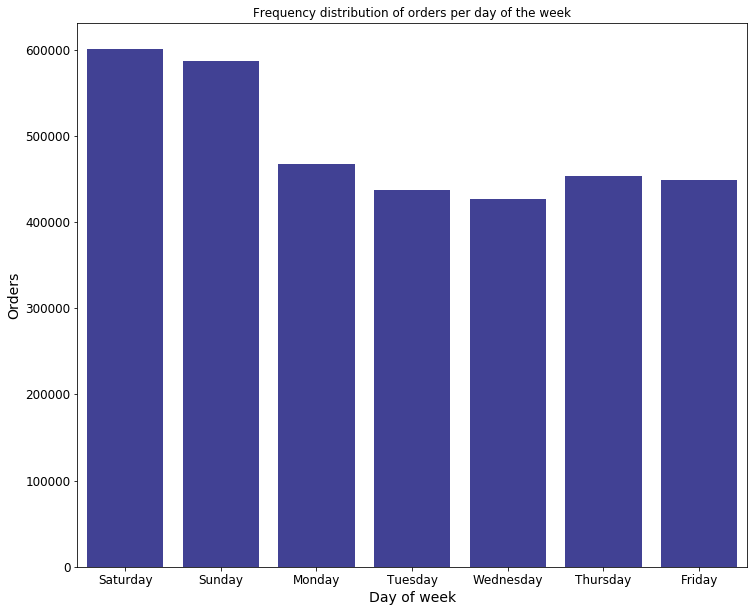

In [106]:
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(x="order_dow", data=orders, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xlabel("Day of week")
plt.title("Frequency distribution of orders per day of the week")
labels = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ax.set_xticklabels(labels)
plt.show()

Most purchases are made on Weekends with a low on Wednesday.

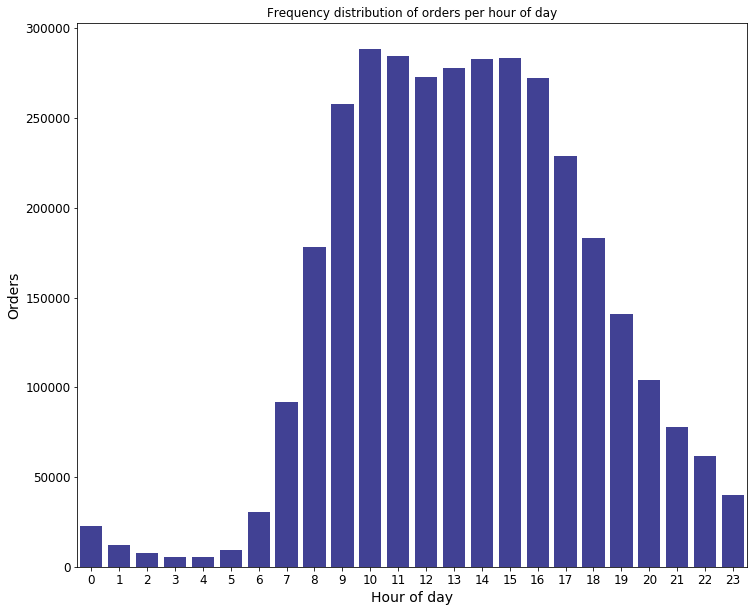

In [108]:
plt.figure(figsize=(12,10))
sns.countplot(x="order_hour_of_day", data=orders, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xlabel("Hour of day")
plt.title("Frequency distribution of orders per hour of day")
plt.show()

Most orders are placed between 9am and 16pm.

In [109]:
df_past_orders_info['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

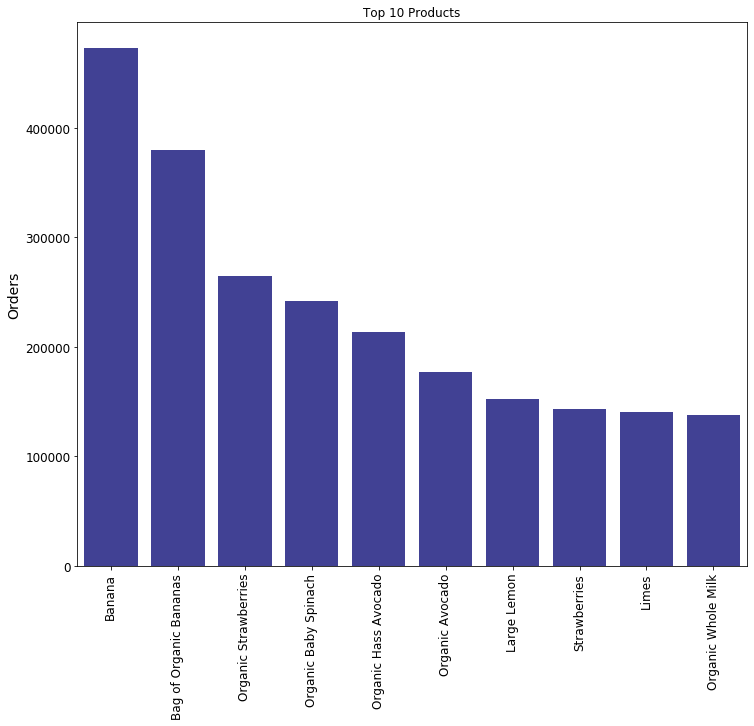

In [110]:
top_10_products = df_past_orders_info["product_name"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_products.index, top_10_products.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Products')
plt.show()

The 10 most ordered products are mostly organic, fruits or vegetables.

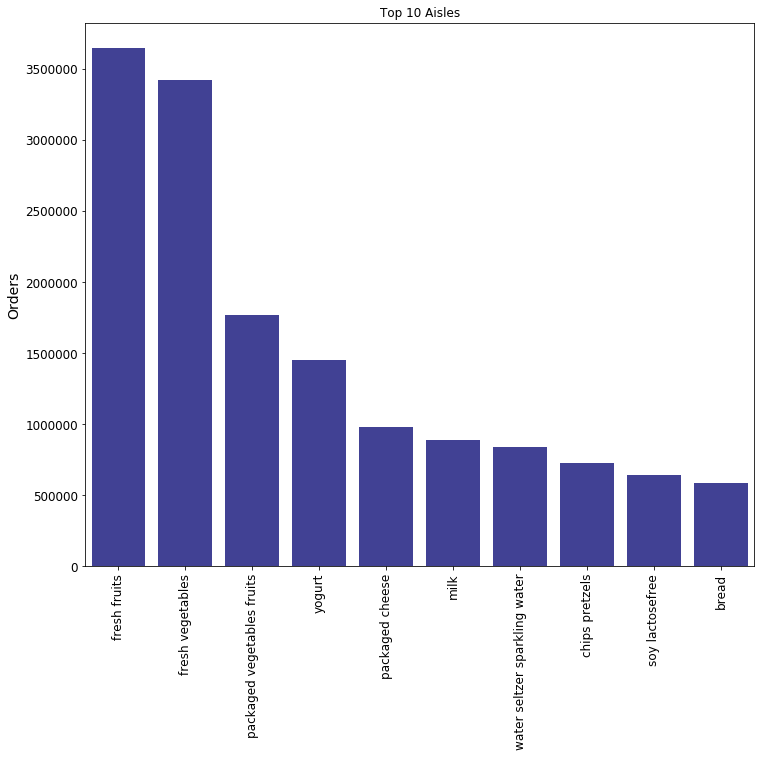

In [111]:
top_10_aisles = df_past_orders_info["aisle"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_aisles.index, top_10_aisles.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Aisles')
plt.show()

Not surprizing, the top aisles are the ones with fresh fruit and vegetable.

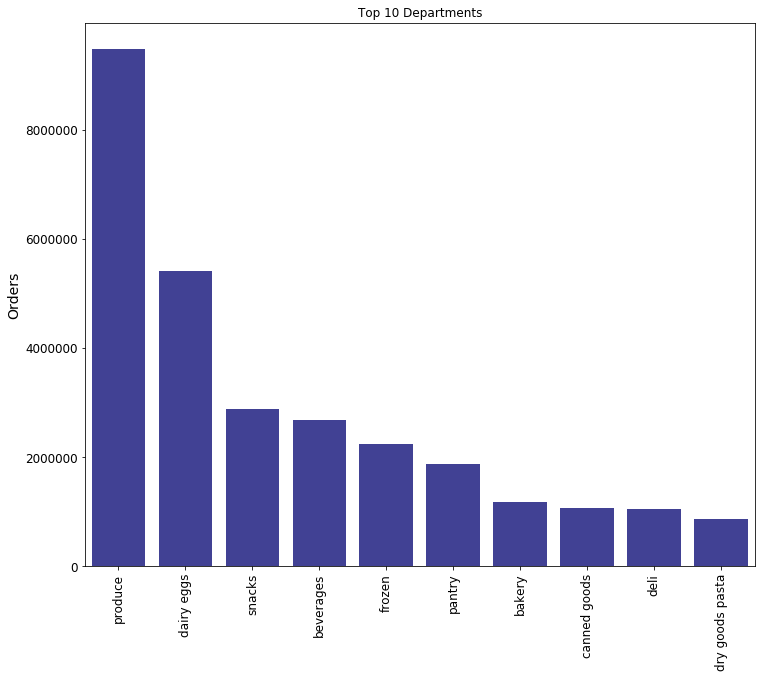

In [112]:
top_10_departments = df_past_orders_info["department"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_departments.index, top_10_departments.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Departments')
plt.show()

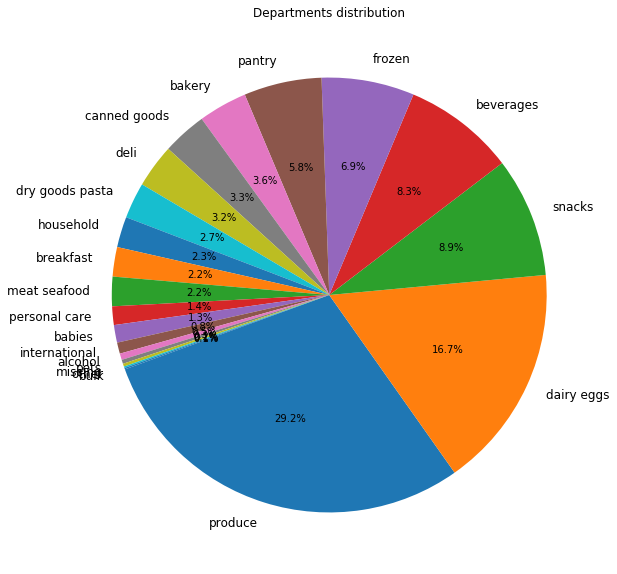

In [113]:
plt.figure(figsize=(10,10))
dept_distn = df_past_orders_info['department'].value_counts()
labels = (np.array(dept_distn.index))
sizes = (np.array((dept_distn / dept_distn.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution")
plt.show()

From the above graph we can see that the top 3 departments (Produce, Dairy Eggs, Snacks) make up more than 50% of the products ordered.

# 1st Approach 

In [17]:
#merge order, user and product ID into one df
df_new = pd.merge(orders, order_products_prior[['order_id', 'product_id']], on="order_id", how='inner')
df_new.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,2539329,1,prior,1,2,8,NaN,196
1,2539329,1,prior,1,2,8,NaN,14084
2,2539329,1,prior,1,2,8,NaN,12427
3,2539329,1,prior,1,2,8,NaN,26088
4,2539329,1,prior,1,2,8,NaN,26405


In [18]:
df = pd.merge(df_new, products[['product_id', 'product_name']], on="product_id", how='inner')
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name
0,2539329,1,prior,1,2,8,NaN,196,Soda
1,2398795,1,prior,2,3,7,15.0,196,Soda
2,473747,1,prior,3,3,12,21.0,196,Soda
3,2254736,1,prior,4,4,7,29.0,196,Soda
4,431534,1,prior,5,4,15,28.0,196,Soda


In [19]:
df.shape

(32434489, 9)

In [20]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name
0,2539329,1,prior,1,2,8,NaN,196,Soda
1,2398795,1,prior,2,3,7,15.0,196,Soda
2,473747,1,prior,3,3,12,21.0,196,Soda
3,2254736,1,prior,4,4,7,29.0,196,Soda
4,431534,1,prior,5,4,15,28.0,196,Soda


In [21]:
#dropping column with missing values
df = df.drop(['days_since_prior_order'], axis = 1)
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,product_id,product_name
0,2539329,1,prior,1,2,8,196,Soda
1,2398795,1,prior,2,3,7,196,Soda
2,473747,1,prior,3,3,12,196,Soda
3,2254736,1,prior,4,4,7,196,Soda
4,431534,1,prior,5,4,15,196,Soda


In [34]:
#cast to str values
df['product_id'] = df['product_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['product_name'] = df['product_name'].astype(str)
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,product_id,product_name
0,2539329,1,prior,1,2,8,196,Soda
1,2398795,1,prior,2,3,7,196,Soda
2,473747,1,prior,3,3,12,196,Soda
3,2254736,1,prior,4,4,7,196,Soda
4,431534,1,prior,5,4,15,196,Soda


In [36]:
df.isnull().sum()

order_id             0
user_id              0
eval_set             0
order_number         0
order_dow            0
order_hour_of_day    0
product_id           0
product_name         0
dtype: int64

In [37]:
# remove missing values
#df.dropna(inplace=True)

In [109]:
#take sample of 1'000'000 to reduce running time
df_sample = df.sample(n=1000000, random_state=1)

In [110]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 17336906 to 13125034
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   order_id           1000000 non-null  int64 
 1   user_id            1000000 non-null  object
 2   eval_set           1000000 non-null  object
 3   order_number       1000000 non-null  int64 
 4   order_dow          1000000 non-null  int64 
 5   order_hour_of_day  1000000 non-null  int64 
 6   product_id         1000000 non-null  object
 7   product_name       1000000 non-null  object
dtypes: int64(4), object(4)
memory usage: 68.7+ MB


In [111]:
customers = df_sample["user_id"].unique().tolist()
len(customers)

169684

In [112]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df_sample[df_sample['user_id'].isin(customers_train)]
validation_df = df_sample[~df_sample['user_id'].isin(customers_train)]

In [113]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["user_id"] == i]["product_id"].tolist()
    purchases_train.append(temp)

100%|███████████████████████████████████████████████████████████████████████| 152716/152716 [12:47:35<00:00,  3.32it/s]


In [114]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['user_id'].unique()):
    temp = validation_df[validation_df["user_id"] == i]["product_id"].tolist()
    purchases_val.append(temp)

100%|████████████████████████████████████████████████████████████████████████████| 16968/16968 [10:36<00:00, 26.67it/s]


In [115]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(8293434, 9005740)

In [116]:
# save word2vec model
model.save("word2vec_2.model")

In [117]:
model.init_sims(replace=True)

In [118]:
print(model)

Word2Vec(vocab=16169, size=100, alpha=0.03)


In [119]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(16169, 100)

In [120]:
products = train_df[["product_id", "product_name"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='product_id', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('product_id')['product_name'].apply(list).to_dict()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [121]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms 

In [122]:
products_dict['10032']

['Cola Soft Drink']

In [123]:
similar_products(model['10032'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('Dog Food With Beef in Meaty Juices', 0.6465246081352234),
 ('Light Blackberry Yogurt', 0.6453588008880615),
 ("Bold Salt 'n Vinegar Almonds", 0.6373338103294373),
 ('Whipped Vanilla Frosting', 0.6372911334037781),
 ('Brown Basmati Ready Rice', 0.6370280385017395),
 ('Makeup Remover Cleansing Towelettes Refill', 0.6356369256973267)]

Product Recommendations do not seem to be very close to the random product (Cola Soft Drink) chosen as a reference

# 2nd Approach

Let's try a different approach to predict recommend similar products more accurately

## Products

In [123]:
#load data
products = pd.read_csv("products.csv")
departments = pd.read_csv("departments.csv")
aisles = pd.read_csv("aisles.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")

In [124]:
# Make everything lowercase.
products['Products_mod'] = products['product_name'].str.lower()

# Clean special characters.
products['Products_mod'] = products['Products_mod'].str.replace('\W', ' ')

#consider stemming (word root)

# Split products into terms: Tokenize.
products['Products_mod'] = products['Products_mod'].str.split()
products.head()

,product_id,product_name,aisle_id,department_id,Products_mod
0,1,Chocolate Sandwich Cookies,61,19,"[chocolate, sandwich, cookies]"
1,2,All-Seasons Salt,104,13,"[all, seasons, salt]"
2,3,Robust Golden Unsweetened Oolong Tea,94,7,"[robust, golden, unsweetened, oolong, tea]"
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,"[smart, ones, classic, favorites, mini, rigato..."
4,5,Green Chile Anytime Sauce,5,13,"[green, chile, anytime, sauce]"


In [125]:
#add information on department and aisle to the products
products = pd.merge(products, departments, on="department_id", how='outer')
products = pd.merge(products, aisles, on="aisle_id", how='outer')
products.head()

,product_id,product_name,aisle_id,department_id,Products_mod,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,"[chocolate, sandwich, cookies]",snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,"[nutter, butter, cookie, bites, go, pak]",snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,"[danish, butter, cookies]",snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,"[gluten, free, all, natural, chocolate, chip, ...",snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,"[mini, nilla, wafers, munch, pack]",snacks,cookies cakes


In [126]:
# Add the aisle and department information to the data that will go into the model.

for index, row in tqdm(products.iterrows()):
    row['Products_mod'].append(row['aisle'])
    row['Products_mod'].append(row['department'])

products.head()

49688it [00:05, 8444.79it/s]


,product_id,product_name,aisle_id,department_id,Products_mod,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,"[chocolate, sandwich, cookies, cookies cakes, ...",snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,"[nutter, butter, cookie, bites, go, pak, cooki...",snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,"[danish, butter, cookies, cookies cakes, snacks]",snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,"[gluten, free, all, natural, chocolate, chip, ...",snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,"[mini, nilla, wafers, munch, pack, cookies cak...",snacks,cookies cakes


In [127]:
from gensim.models import Word2Vec

# In order to make TSNE a little bit quicker and for memory efficiency we're going to use 20 dimensions: size=20
# In order to make sure all words are used in training the model, we're going to set a large - window=10. 
w2vec_model = Word2Vec(list(products['Products_mod']), size=20, window=10, min_count=1, workers=4)

In [128]:
# Create  dictionaries to obtain product vectors

prod_word = dict()
for w in w2vec_model.wv.vocab:
    prod_word[w] = w2vec_model[w]

In [129]:
# VECTOR CALCULATION FOR PRODUCTS
# Cycle through each word in the product name to generate the vector.
prods_w2v = dict()
for row, product in tqdm(products.iterrows()):
    word_vector = list()
    for word in product['Products_mod']:
        word_vector.append(prod_word[word])

    prods_w2v[product['product_id']] = np.average(word_vector, axis=0)

49688it [00:05, 9145.17it/s]


In [130]:
# Save vector values in list form to the dataframe. 
products['vectors']=prods_w2v.values()

In [131]:
products.vectors[0]

(-0.4591697,
 3.5028949,
 -0.89085436,
 2.8362005,
 0.876142,
 0.5795392,
 1.0050905,
 -0.40805572,
 -0.79392177,
 0.92840624,
 2.507697,
 -0.5482615,
 0.66840154,
 1.2964951,
 -0.1675477,
 -0.45929322,
 -1.0938169,
 2.084575,
 -1.7902025,
 -0.17734194)

In [132]:
# Create a dataframe to make it easier to sample. 
# Around 5000 examples is acceptable. 
df_tsne_data = products.sample(n=5000, random_state=1)

In [133]:
df_tsne_data.head()

,product_id,product_name,aisle_id,department_id,Products_mod,department,aisle,vectors
22401,35807,Moisture Outlast Age Defying Beauty Bar 3.75 o...,127,11,"[moisture, outlast, age, defying, beauty, bar,...",personal care,body lotions soap,"(-0.30952835, 1.2368098, 0.11190534, 0.3798840..."
14796,12187,Ground Coffee Classico Medium Roast,26,7,"[ground, coffee, classico, medium, roast, coff...",beverages,coffee,"(-0.87528974, 1.9106483, 0.2749686, -1.5110573..."
38552,31670,Buttermilk Complete Pancake Mix,130,14,"[buttermilk, complete, pancake, mix, hot cerea...",breakfast,hot cereal pancake mixes,"(-0.79104424, 1.7147344, -0.3796676, 2.402764,..."
11805,8416,Organic Master Brew Kombucha Dragonfruit Lemon...,94,7,"[organic, master, brew, kombucha, dragonfruit,...",beverages,tea,"(-1.0022902, 0.9229798, -0.47185242, 0.5597448..."
9336,46306,100% Pure Avocado Oil,19,13,"[100, pure, avocado, oil, oils vinegars, pantry]",pantry,oils vinegars,"(-1.0439683, 1.324132, 2.1402419, 0.88396114, ..."


In [134]:
# Import the SKLEARN LIBRARY
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=23)
new_values = tsne_model.fit_transform(list(df_tsne_data['vectors']))

In [135]:
# We want to recover also the texts to understand what's going on. 
w2vec_tsne = df_tsne_data['vectors']
sentences = df_tsne_data['Products_mod']

In [136]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

%matplotlib inline


x = list()
y = list()
for i in range(new_values.shape[0]):
    x.append(new_values[i][0])
    y.append(new_values[i][1])
    
# Create random data with numpy

# Create a trace
trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    text = sentences,
    hoverinfo = 'text',
    marker=dict(color=list(df_tsne_data['department_id']), colorscale='Viridis',),

)

data = [trace]

# Plot and embed in ipython notebook!
pyo.plot(data, filename='basic-scatter_normal.html')

'basic-scatter_normal.html'

Train model - using annoy with the previously created vectors as input

In [137]:
from annoy import AnnoyIndex
import random

In [138]:
# Number of dimensions of the vector annoy is going to store. 
# Make sure it's the same as the word2vec we're using!
f = 20

# Specify the metric to be used for computing distances. 
u = AnnoyIndex(f, metric='manhattan') 

# We can sequentially add items.
for index, row in products.iterrows():
    u.add_item(row['product_id'], row['vectors'])

# Number of trees for queries. When making a query the more trees the easier it is to go down the right path. 
u.build(10) # 10 trees

True

In [139]:
products_select = products[["product_id", "product_name"]]

In [140]:
#cast to str values
products_select['product_name'] = products_select['product_name'].astype(str)

In [141]:
products_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49688 entries, 0 to 49687
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    49688 non-null  int64 
 1   product_name  49688 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [142]:
# create product-ID and product-description dictionary
prods_dict = products_select.groupby('product_id')['product_name'].apply(list).to_dict()

In [143]:
#define function to recommend similar products
#input is the product id and the number of recommended products (n)

def similar_products(prod_id, n = 5):
    
    # extract most similar products for the input id
    ms = u.get_nns_by_item(prod_id, n)
    
    # extract name and similarity score of the similar products
    new_ms = list()
    for x in ms:
        prod_name = {key: value for key, value in prods_dict.items() if key == x}
        new_ms.append(prod_name)
        
    return new_ms       

In [144]:
similar_products(1,5)

[{1: ['Chocolate Sandwich Cookies']},
 {37160: ['Cookies, Chocolate Chocolate Chip, Crunchy, Mini']},
 {16143: ['Chocolate Chunk Cookies']},
 {38649: ['Quinoa Cookies Chocolate Chip']},
 {23932: ['Chocolate Creme Sandwich Cookies']}]

These product recommendations seem to be much closer to the initial product.

Let's compare the results if we use get_nns_by_vector instead of item.

In [151]:
print(products.vectors[products.product_name=='Chocolate Sandwich Cookies'])

0    (-0.4591697, 3.5028949, -0.89085436, 2.8362005...
Name: vectors, dtype: object


In [33]:
def similar_vectors(v, n = 5):
    
    # extract most similar products for the input vector
    ms = u.get_nns_by_vector(v, n, search_k=-1, include_distances=False)
    
    # extract name and similarity score of the similar products
    new_ms = list()
    for x in ms:
        prod_name = {key: value for key, value in prods_dict.items() if key == x}
        new_ms.append(prod_name)
        
    return new_ms       

In [153]:
similar_vectors((-0.4591697,
 3.5028949,
 -0.89085436,
 2.8362005,
 0.876142,
 0.5795392,
 1.0050905,
 -0.40805572,
 -0.79392177,
 0.92840624,
 2.507697,
 -0.5482615,
 0.66840154,
 1.2964951,
 -0.1675477,
 -0.45929322,
 -1.0938169,
 2.084575,
 -1.7902025,
 -0.17734194))

[{1: ['Chocolate Sandwich Cookies']},
 {37160: ['Cookies, Chocolate Chocolate Chip, Crunchy, Mini']},
 {16143: ['Chocolate Chunk Cookies']},
 {38649: ['Quinoa Cookies Chocolate Chip']},
 {23932: ['Chocolate Creme Sandwich Cookies']}]

We can observe that the result - using the product as input - is exactly the same

In [154]:
similar_vectors((-0.4591697,
 3.5028949,
 -0.89085436,
 2.8362005,
 0.876142,
 0.5795392,
 1.0050905,
 -0.40805572,
 -0.79392177,
 0.92840624,
 2.507697,
 -0.5482615,
 0.66840154,
 1.2964951,
 -0.1675477,
 -0.45929322,
 -1.0938169,
 2.084575,
 -1.7902025,
 -0.17734194))== similar_products(1,5)

True

## Baskets

Create Vectors for Baskets and Orders

In [36]:
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [37]:
order_products = pd.merge(order_products_prior, products[['product_id', 'product_name']], on="product_id", how='left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,2,28985,2,1,Michigan Organic Kale
2,2,9327,3,0,Garlic Powder
3,2,45918,4,1,Coconut Butter
4,2,30035,5,0,Natural Sweetener


In [74]:
#append department and aisle to baskets
order_products = pd.merge(order_products, products[['product_id','department_id']], on="product_id", how='outer')
order_products = pd.merge(order_products, products[['product_id','aisle_id']], on="product_id", how='outer')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle,Products_mod,department_id,aisle_id
0,2.0,33120,1.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
1,26.0,33120,5.0,0.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
2,120.0,33120,13.0,0.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
3,327.0,33120,5.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
4,390.0,33120,28.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86


In [75]:
# Make everything lowercase.
order_products['Products_mod'] = order_products['product_name'].str.lower()

# Clean special characters.
order_products['Products_mod'] = order_products['Products_mod'].str.replace('\W', ' ')

#consider stemming (word root)

# Split products into terms: Tokenize.
order_products['Products_mod'] = order_products['Products_mod'].str.split()
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle,Products_mod,department_id,aisle_id
0,2.0,33120,1.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
1,26.0,33120,5.0,0.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
2,120.0,33120,13.0,0.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
3,327.0,33120,5.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86
4,390.0,33120,28.0,1.0,Organic Egg Whites,dairy eggs,eggs,"[organic, egg, whites]",16,86


In [76]:
#limit number of orders to reduce runtime
orders_filter = order_products_prior[order_products_prior.order_id < 100000]

In [77]:
baskets = orders_filter.groupby('order_id')['product_id'].apply(list)

In [78]:
import time
basket_w2v = dict()
for index, row in tqdm(baskets.items()):
    word_vector = list()
    for item_id in row:
        word_vector.append(u.get_item_vector(item_id))
    basket_w2v[index] = np.average(word_vector, axis=0)

93947it [00:04, 19753.43it/s]


In [79]:
#create dataframe from basket list
df_baskets = baskets.to_frame()
df_baskets['vectors']  =   basket_w2v.values()
df_baskets.head()

,product_id,vectors
order_id,,
2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014...","(0.09693860676553515, 1.029512267973688, 0.348..."
3,"[33754, 24838, 17704, 21903, 17668, 46667, 174...","(0.4608045076020062, 1.1676642838865519, -0.04..."
4,"[46842, 26434, 39758, 27761, 10054, 21351, 225...","(-0.37446783024531144, 1.9647282453683705, -0...."
5,"[13176, 15005, 47329, 27966, 23909, 48370, 132...","(0.2469972796165026, 0.8852925915271044, -0.00..."
6,"[40462, 15873, 41897]","(-1.3472444415092468, 1.2235261003176372, 0.49..."


In [80]:
b = AnnoyIndex(f, metric='angular') 
# We can sequentially add items.
for index, row in df_baskets.iterrows():
    b.add_item(row.name, row['vectors'])

# Number of trees for queries. When making a query the more trees the easier it is to go down the right path. 
b.build(10) # 10 trees

True

In [81]:
# create order-ID and product-description dictionary
ords_dict = order_products.groupby('order_id')['product_name'].apply(list).to_dict()

In [82]:
#define function to recommend similar orders / baskets
#input is the order id and the number of recommended products (n)

def similar_orders(order_id, n = 5):
    
    # extract most similar products for the input id
    ms = u.get_nns_by_item(order_id, n)
    
    # extract name and similarity score of the similar products
    new_ms = list()
    for x in ms:
        prod_name = {key: value for key, value in ords_dict.items() if key == x}
        new_ms.append(prod_name)
        
    return new_ms   

In [83]:
similar_orders(2,5)

[{2.0: ['Organic Egg Whites',
   'Michigan Organic Kale',
   'Garlic Powder',
   'Coconut Butter',
   'Natural Sweetener',
   'Carrots',
   'Original Unflavored Gelatine Mix',
   'All Natural No Stir Creamy Almond Butter',
   'Classic Blend Cole Slaw']},
 {16820.0: ['Banana',
   'Organic Half & Half',
   'Organic Whole Milk',
   'Organic Baby Spinach Salad',
   'Organic Unsweetened Almond Milk',
   "Organic D'Anjou Pears",
   'Organic Fuji Apple',
   'Organic Roasted Turkey Breast',
   'Organic Roasted Sliced Chicken Breast',
   'Uncured Black Forest Ham',
   'Whipped Cream Cheese',
   'Organic  Sweet & Salty Peanut Pretzel Granola Bars',
   'Honey Oat Crunch Trail Mix Crunchy Granola Bars',
   'Pretzel Rods',
   'Maple Greek Yogurt',
   'Layered Dark Chocolate Coconut Granola Bars',
   'Blueberry Yogurt',
   '0% Fat Strawberry Greek Yogurt',
   'Artisanal Nonfat Coffee Greek Yogurt']},
 {10927.0: ['Unsalted Butter',
   'Organic Large Grade A Brown Eggs',
   'Large Grapefruit',
   'Org

In the case of baskets, comparing the recommendations is a bit more subjective but it seems that the recommendations do make sense and in the example above are fairly similar (organic, fresh products)

In [84]:
#to visualize similarities we're going to use the tsne library used previously in this notebook

In [91]:
#add department to the basket df
df_baskets['department_id'] = order_products['department_id']
df_baskets['Products_mod'] = order_products['Products_mod']
df_baskets.head()

,product_id,vectors,department,Products_mod,department_id
order_id,,,,,
2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014...","(0.09693860676553515, 1.029512267973688, 0.348...",dairy eggs,"[organic, egg, whites]",16
3,"[33754, 24838, 17704, 21903, 17668, 46667, 174...","(0.4608045076020062, 1.1676642838865519, -0.04...",dairy eggs,"[organic, egg, whites]",16
4,"[46842, 26434, 39758, 27761, 10054, 21351, 225...","(-0.37446783024531144, 1.9647282453683705, -0....",dairy eggs,"[organic, egg, whites]",16
5,"[13176, 15005, 47329, 27966, 23909, 48370, 132...","(0.2469972796165026, 0.8852925915271044, -0.00...",dairy eggs,"[organic, egg, whites]",16
6,"[40462, 15873, 41897]","(-1.3472444415092468, 1.2235261003176372, 0.49...",dairy eggs,"[organic, egg, whites]",16


In [92]:
# Create a dataframe to make it easier to sample. 
# Around 10000 examples is acceptable. 
basket_tsne_data = df_baskets.sample(n=10000, random_state=1)
basket_tsne_data.head()

,product_id,vectors,department,Products_mod,department_id
order_id,,,,,
66764,"[33401, 30953, 37646, 6860]","(0.6191958412528038, 0.5446031130850315, 0.161...",produce,"[michigan, organic, kale]",4
88439,"[27845, 41290, 21137, 38689, 49683, 45309]","(0.32436175147692364, 1.8129418243964512, -0.0...",pantry,"[garlic, powder]",13
74920,[10326],"(0.8305402994155884, 0.7020441293716431, 0.433...",produce,"[michigan, organic, kale]",4
45742,"[40174, 10912, 8277, 33125, 7781, 13176, 4793,...","(0.12356960126443912, 1.0973681984959465, -0.0...",produce,"[michigan, organic, kale]",4
76649,"[13263, 1463, 46676, 11499, 6375]","(-0.053331265971064565, 2.7680059909820556, -0...",produce,"[michigan, organic, kale]",4


In [93]:
# Import the SKLEARN LIBRARY
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=23)
new_values = tsne_model.fit_transform(list(basket_tsne_data['vectors']))

In [94]:
# We want to recover also the texts to understand what's going on. 
w2vec_tsne = basket_tsne_data['vectors']
sentences = basket_tsne_data['Products_mod']

In [95]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

%matplotlib inline


x = list()
y = list()
for i in range(new_values.shape[0]):
    x.append(new_values[i][0])
    y.append(new_values[i][1])
    
# Create random data with numpy

# Create a trace
trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    text = sentences,
    hoverinfo = 'text',
    marker=dict(color=list(basket_tsne_data['department_id']), colorscale='Viridis',),

)

data = [trace]

# Plot and embed in ipython notebook!
pyo.plot(data, filename='basic-scatter_normal.html')

'basic-scatter_normal.html'

There is no clear pattern to be observed in the plot in terms of department_id. This could due to different reason:
- since this a 2D picture, a third dimension could explain more of the similarity
- the added department_id is actually not the most relevant for explaining similarity (and they are common in most baskets)
- the recommended baskets are actually not that similar